## Import Modules

In [1]:
from ultralytics import YOLO
import supervision as sv
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import csv
import os


## Load Model

In [2]:
model = YOLO('yolov8s.pt')  # small model, better accuracy than nano
model.fuse() # for faster inference

# If GPU available, use it with FP16 for speed
if torch.cuda.is_available():
    model.to('cuda')
    try:
        model.model.half()
    except Exception:
        pass

YOLOv8s summary (fused): 72 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs


In [3]:
#dict mapping class_id to class_name
CLASS_NAME_DICT = model.model.names

#CLASS_NAME_DICT

In [4]:
# class_id of intrest
classes = [2, 3, 5, 7]

## Plot Frame from Video

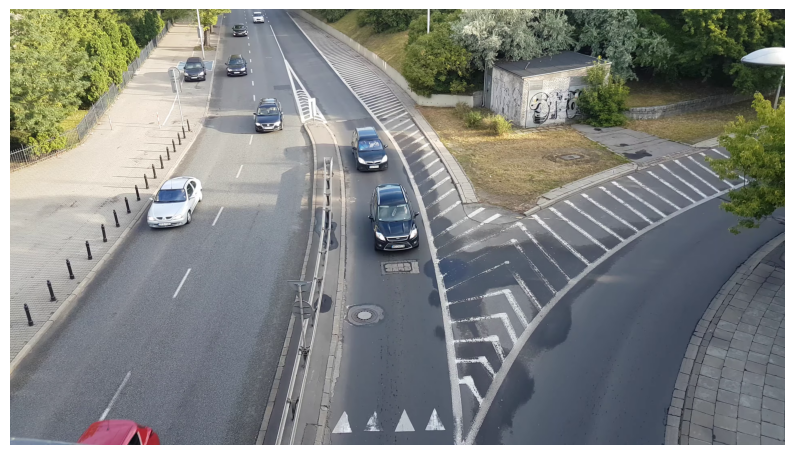

In [5]:
# create frame generator
generator = sv.get_video_frames_generator("input-video.mp4")

# get the first frame
iterator = iter(generator)
frame = next(iterator)
sv.plot_image(frame, (10, 10))

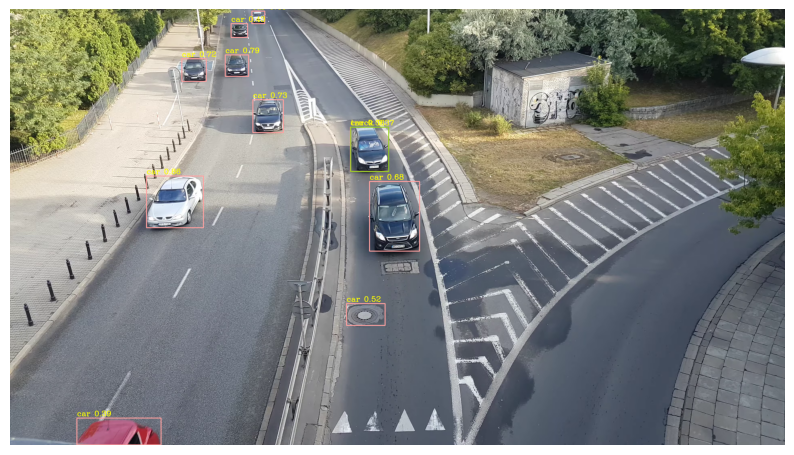

In [6]:
# detect vehicles from the frame
results = model(frame, verbose=False)[0]

# convert to detections
detections = sv.Detections.from_ultralytics(results)
# only consider classes which we require
detections = detections[np.isin(detections.class_id, classes)]

# create instance of box annotator
box_annotator = sv.BoxAnnotator(thickness=3)
# annotate in the frame
annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=detections)

# format labels
labels = []
for confidence, class_id in zip(detections.confidence, detections.class_id):
    label = f'{CLASS_NAME_DICT[class_id]} {confidence:0.2f}'
    labels.append(label)

# overlay labels in the boundingbox
for box, label in zip(detections.xyxy, labels):
    x1, y1, x2, y2 = box.astype(int)

    # add the label above box
    cv2.putText(
        annotated_frame, label, (x1, y1-10), fontFace=cv2.FONT_HERSHEY_COMPLEX,
        fontScale=1.2, color=(0,255,255), thickness=2
    )
# plot the image
sv.plot_image(annotated_frame, (10, 10))

In [7]:
sv.VideoInfo.from_video_path('input-video.mp4')

VideoInfo(width=3840, height=2160, fps=30, total_frames=9184)

In [8]:
# two horizontal lines dividing 3 lanes
LANE_X = [470, 800]
COUNT_LINE_Y = 500

# Counter storage
lane_counts = [0, 0, 0]  # 3 lanes
counted_ids = set()

# list of detected vehicles
new_detections = []

# initialize trackers
byte_tracker = sv.ByteTrack()

# create box annotator
box_annotator = sv.BoxAnnotator(thickness=2)

# create trace annotator
trace_annotator = sv.TraceAnnotator(thickness=2, trace_length=60)

In [9]:
# csv file setup
csv_file = "laneCount.csv"
file_exists = os.path.isfile(csv_file)

# open file to write headers
with open(csv_file, mode="a", newline="") as file:
    write = csv.writer(file)
    if not file_exists:
        write.writerow(["Vehicle ID", "Lane Number", "Frame Count", "Timestamp (s)"])

In [10]:
# define the function for process frames
def process_frame(frame, frame_id, fps):
    # resize first for faster inference
    frame = cv2.resize(frame, (1280, 720))
    # get result from model
    results = model(frame, verbose=False)[0]
    # convert to detections
    detections = sv.Detections.from_ultralytics(results)
    # only consider classes which we require
    detections = detections[np.isin(detections.class_id, classes)]
    # tracking detections
    detections = byte_tracker.update_with_detections(detections)

    # lane assign and tracking
    for box, tracker_id in zip(detections.xyxy, detections.tracker_id):
        x1, y1, x2, y2 = box.astype(int)
        cx = (x1 + x2) // 2  # center x-coordinate of vehicle
        cy = (y1 + y2) // 2  # center y-coordinate of vehicle

        # Check if vehicle crosses the count line
        if abs(cy - COUNT_LINE_Y) <= 10:
            if tracker_id not in counted_ids:
                counted_ids.add(tracker_id)
                # Determine lane based on center position
                if cx < LANE_X[0]:
                    lane_counts[0] += 1
                    lane_number = 1
                elif cx < LANE_X[1]:
                    lane_counts[1] += 1
                    lane_number = 2
                else:
                    lane_counts[2] += 1
                    lane_number = 3
                # call func. to write in csv
                write_csv(tracker_id, lane_number, frame_id, fps)

    # create labels
    labels = []
    for confidence, class_id, tracker_id in zip(detections.confidence, detections.class_id, detections.tracker_id):
        label = f'{tracker_id} {CLASS_NAME_DICT[class_id]} {confidence:0.2f}'
        labels.append(label)

    # update trace annotator
    annotated_frame = trace_annotator.annotate(scene=frame.copy(), detections=detections)
    # update box annotator
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)

    # overlay labels in the boundingbox
    for box, label in zip(detections.xyxy, labels):
        x1, y1, x2, y2 = box.astype(int)

        # add the label above box
        cv2.putText(
            annotated_frame, label, (x1, y1-10), fontFace=cv2.FONT_HERSHEY_COMPLEX,
            fontScale=0.4, color=(0,255,255), thickness=2
        )

    # draw counting line
    cv2.line(annotated_frame, (0, COUNT_LINE_Y), (1280, COUNT_LINE_Y), (0, 255, 255), 2)
    # draw lane dividers
    for x in LANE_X:
        cv2.line(annotated_frame, (x, 0), (x, 720), (255, 0, 255), 2)

    # show live counts
    for i, count in enumerate(lane_counts):
        cv2.putText(annotated_frame, f"Lane {i+1}: {count}", (20, 40 + i * 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

    return annotated_frame

In [11]:
def write_csv(tracker_id, lane_number, frame_id, fps):
    # timestamp in sec
    timestp = round(frame_id/fps, 2)

    # write in csv
    with open(csv_file, mode="a", newline="") as file:
        write = csv.writer(file)
        write.writerow([tracker_id, lane_number, frame_id, timestp])


In [12]:
def summary(lane_counts):
    # print per lane vehicle counts
    for i, count in enumerate(lane_counts, start=1):
        print(f"Lane {i} has: {count} vehicles")

In [13]:
# run program
video_path = "input-video.mp4"
# get input from video
video_cap = cv2.VideoCapture(video_path)
# set frameId and fps got from above cell [7]
frame_id = 0
fps = 30

while True:
    success, frame = video_cap.read()
    if not success:
        break
    # increment frmae id
    frame_id += 1
    # resize frame
    frame = cv2.resize(frame, (1280, 720))
    # convert to RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # process the frame
    processed_frame = process_frame(frame, frame_id, fps)
    # display the frame
    cv2.imshow("Traffic Flow Analysis", processed_frame)

    # exit if any key pressed
    if cv2.waitKey(1) & 0xFF !=255:
        break

video_cap.release()
cv2.destroyAllWindows()

summary(lane_counts)

Lane 1 has: 1 vehicles
Lane 2 has: 0 vehicles
Lane 3 has: 0 vehicles
